# Exploring dsx, tj, chinmo clusters

We are interested in genes that are targets of *dsx* and how they behave differently in testis and ovary. Here I look at cell clusters marked by {dsx, tj, chinmo} and see how expression patterns in dsx targets {skd, msn, br} change between cluster and between {testis, ovary}. 

First I did a standard library size normalization and then plot violin plots separated by different clusters {dsx, tj, chinmo}, by different target genes {skd, msn, br} and colored by different tissues {testis, ovary}.

In [1]:
# %load ../start.py
# Load useful extensions

# Activate the autoreload extension for easy reloading of external packages
%reload_ext autoreload
%autoreload 2

# Trun on the water mark
%reload_ext watermark
%watermark -u -d -g

# Load ipycache extension
%reload_ext ipycache
from ipycache import CacheMagics
CacheMagics.cachedir = '../cachedir'

# The usual suspects
import os
import numpy as np
import pandas as pd

# plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_context('poster')

# Turn off scientific notation
np.set_printoptions(precision=5, suppress=True)


last updated: 2017-10-13 
Git hash: bd535da7ac7a1f4ef3ccae2e7674b807d504a624


In [2]:
# imports
import seaborn as sns
sns.set_style('white')
sns.set_context('notebook')
sns.mpl.rc("figure", figsize=(10, 10))

In [3]:
# functions
def reshape(df, tissue):
    dsx = symbol2fbgn['dsx']
    skd = symbol2fbgn['skd']
    msn = symbol2fbgn['msn']
    br = symbol2fbgn['br']
    tj = symbol2fbgn['tj']
    chinmo = symbol2fbgn['chinmo']

    dsx_plus = df[df[dsx] > 1].index
    tj_plus = df[df[tj] > 1].index
    chinmo_plus = df[df[chinmo] > 1].index

    subset = df[[skd, msn, br]].copy()
    subset.columns = ['skd', 'msn', 'br']
    subset = subset.unstack().reset_index(level=0)
    subset.columns = ['gene', 'count']

    subset['dsx'] = 'dsx -'
    subset['tj'] = 'tj -'
    subset['chinmo'] = 'chinmo -'

    mask = subset.index.isin(dsx_plus)
    subset.loc[mask, 'dsx'] = 'dsx + '

    mask = subset.index.isin(tj_plus)
    subset.loc[mask, 'tj'] = 'tj +'

    mask = subset.index.isin(chinmo_plus)
    subset.loc[mask, 'chinmo'] = 'chinmo +'
    subset['tissue'] = tissue
    
    return subset

In [4]:
# get data
testis = pd.read_csv('../../output/single_cell_matrix_testis.tsv', sep='\t', index_col=0)
ovary = pd.read_csv('../../output/single_cell_matrix_ovary.tsv', sep='\t', index_col=0)

In [5]:
# Make look up tables
fbgn2symbol = testis['gene_symbol'].to_dict()
symbol2fbgn = {}
for k, v in fbgn2symbol.items():
    symbol2fbgn[v] = k

In [6]:
# Normalize data (count / libsize * 10000)
testis_d = testis.drop('gene_symbol', axis=1)
testis_norm = testis_d / testis_d.sum() * 10**4

ovary_d = ovary.drop('gene_symbol', axis=1)
ovary_norm = ovary_d / ovary_d.sum() * 10**4

In [9]:
# build table
te = testis_norm.T
ov = ovary_norm.T
merged = pd.concat([reshape(te, 'testis'), reshape(ov, 'ovary')])
merged['logcount'] = np.log10(merged['count'] + 1)

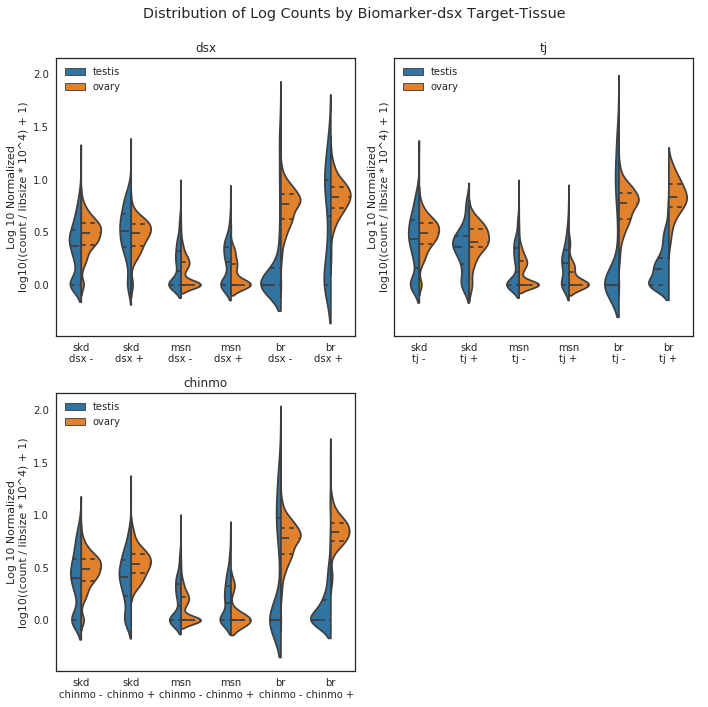

In [14]:
# Plot violins
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharey=True)

merged['grp'] = merged['gene'] + '\n' + merged['dsx']
sns.violinplot('grp', 'logcount',  data=merged, split=True, hue='tissue', ax=ax1, inner='quartile')
ax1.legend(loc='upper left')
ax1.set_title('dsx')
ax1.set_xlabel('')
ax1.set_ylabel('Log 10 Normalized\nlog10((count / libsize * 10^4) + 1)')

merged['grp'] = merged['gene'] + '\n' + merged['tj']
sns.violinplot('grp', 'logcount',  data=merged, split=True, hue='tissue', ax=ax2, inner='quartile')
ax2.legend(loc='upper left')
ax2.set_title('tj')
ax2.set_xlabel('')
ax2.set_ylabel('Log 10 Normalized\nlog10((count / libsize * 10^4) + 1)')

merged['grp'] = merged['gene'] + '\n' + merged['chinmo']
sns.violinplot('grp', 'logcount',  data=merged, split=True, hue='tissue', ax=ax3, inner='quartile')
ax3.legend(loc='upper left')
ax3.set_title('chinmo')
ax3.set_xlabel('')
ax3.set_ylabel('Log 10 Normalized\nlog10((count / libsize * 10^4) + 1)')

ax4.axis('off')
plt.suptitle('Distribution of Log Counts by Biomarker-dsx Target-Tissue')
plt.tight_layout(rect=[0, 0, 1, .95])

plt.savefig('../../output/figures/violin_dsx_tj_chinmo_by_skd_msn_br.png')